# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [10]:
import torch
import numpy as np
GROUP_NUMBER = 13

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [11]:
perm = torch.randperm(X_full.shape[0])
X_full = X_full[perm]
y_full = y_full[perm]

# Split 80 / 20
split = int(0.8 * X_full.shape[0])

X_train = X_full[:split]
y_train = y_full[:split]

X_val = X_full[split:]
y_val = y_full[split:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: torch.Size([2400, 2]) torch.Size([2400, 1])
Val: torch.Size([600, 2]) torch.Size([600, 1])


In [12]:
def init_weights(in_dim, out_dim):
    w = torch.randn(in_dim, out_dim) * 0.1
    b = torch.zeros(1, out_dim)
    w.requires_grad_()
    b.requires_grad_()
    return w, b

# Layer definitions
W1, b1 = init_weights(2, 16)
W2, b2 = init_weights(16, 16)
W3, b3 = init_weights(16, 1)


In [13]:
def relu(z):
    return torch.clamp(z, min=0)

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def forward(X):
    z1 = torch.matmul(X, W1) + b1
    a1 = relu(z1)

    z2 = torch.matmul(a1, W2) + b2
    a2 = relu(z2)

    z3 = torch.matmul(a2, W3) + b3
    y_hat = sigmoid(z3)

    return y_hat


In [14]:
def binary_cross_entropy(y_hat, y):
    eps = 1e-7
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    return loss.mean()


In [15]:
def accuracy(y_hat, y):
    preds = (y_hat >= 0.5).float()
    return (preds == y).float().mean()


In [16]:
lr = 0.05
epochs = 2000

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):

    # ---------- TRAIN ----------
    y_hat_train = forward(X_train)
    loss_train = binary_cross_entropy(y_hat_train, y_train)
    acc_train = accuracy(y_hat_train, y_train)

    loss_train.backward()

    # Manual SGD update
    with torch.no_grad():
        for param in [W1, b1, W2, b2, W3, b3]:
            param -= lr * param.grad
            param.grad.zero_()

    # ---------- VALIDATION ----------
    with torch.no_grad():
        y_hat_val = forward(X_val)
        loss_val = binary_cross_entropy(y_hat_val, y_val)
        acc_val = accuracy(y_hat_val, y_val)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())
    train_accs.append(acc_train.item())
    val_accs.append(acc_val.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Train Loss: {loss_train:.4f} | Val Loss: {loss_val:.4f} | "
              f"Train Acc: {acc_train:.3f} | Val Acc: {acc_val:.3f}")


Epoch    0 | Train Loss: 0.6936 | Val Loss: 0.6929 | Train Acc: 0.515 | Val Acc: 0.535
Epoch  200 | Train Loss: 0.6638 | Val Loss: 0.6620 | Train Acc: 0.613 | Val Acc: 0.615
Epoch  400 | Train Loss: 0.6585 | Val Loss: 0.6551 | Train Acc: 0.613 | Val Acc: 0.615
Epoch  600 | Train Loss: 0.6487 | Val Loss: 0.6423 | Train Acc: 0.613 | Val Acc: 0.615
Epoch  800 | Train Loss: 0.6343 | Val Loss: 0.6230 | Train Acc: 0.613 | Val Acc: 0.615
Epoch 1000 | Train Loss: 0.6135 | Val Loss: 0.5963 | Train Acc: 0.518 | Val Acc: 0.547
Epoch 1200 | Train Loss: 0.5793 | Val Loss: 0.5556 | Train Acc: 0.613 | Val Acc: 0.633
Epoch 1400 | Train Loss: 0.5393 | Val Loss: 0.5092 | Train Acc: 0.690 | Val Acc: 0.743
Epoch 1600 | Train Loss: 0.5123 | Val Loss: 0.4788 | Train Acc: 0.732 | Val Acc: 0.782
Epoch 1800 | Train Loss: 0.4937 | Val Loss: 0.4579 | Train Acc: 0.762 | Val Acc: 0.798


In [17]:
def decision_boundary(model_func, X, y):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = torch.tensor(
        np.c_[xx.ravel(), yy.ravel()],
        dtype=torch.float32
    )

    with torch.no_grad():
        zz = model_func(grid)
        zz = zz.reshape(xx.shape)

    return xx, yy, zz


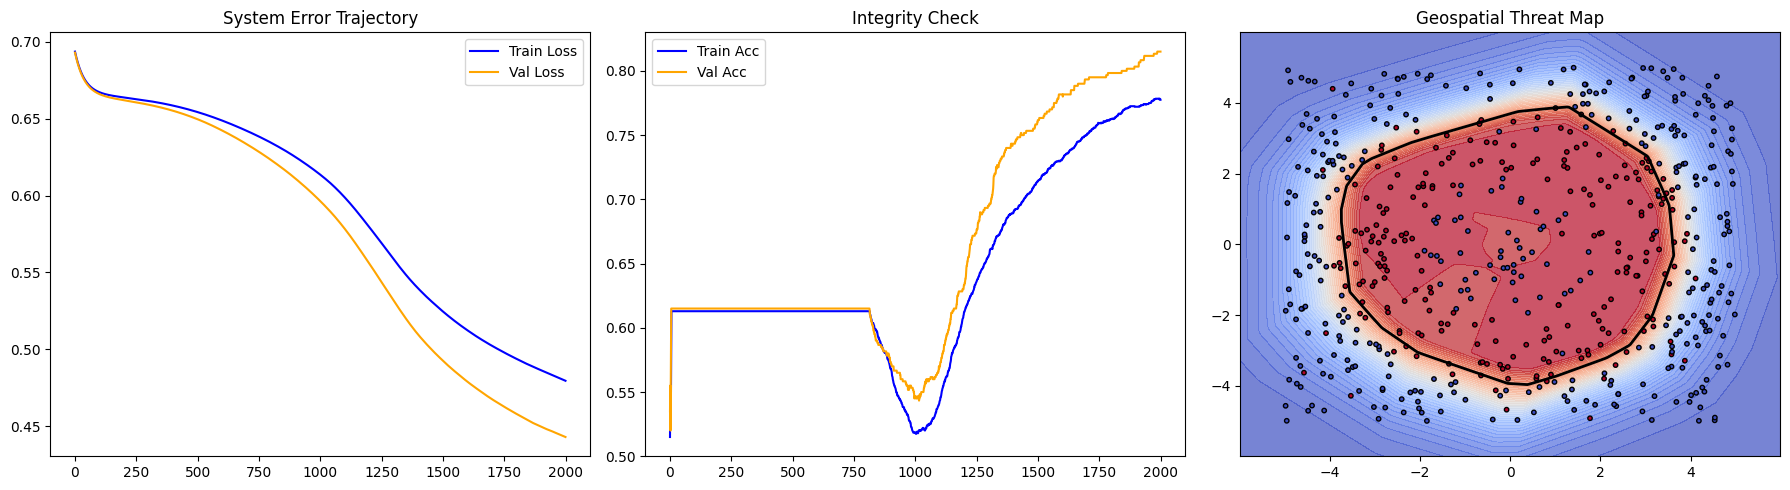

In [18]:
# ===========================================================
# PART 9: GDC HUD
# ===========================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -------- PANEL 1: Loss --------
axes[0].plot(train_losses, label="Train Loss", color="blue")
axes[0].plot(val_losses, label="Val Loss", color="orange")
axes[0].set_title("System Error Trajectory")
axes[0].legend()

# -------- PANEL 2: Accuracy --------
axes[1].plot(train_accs, label="Train Acc", color="blue")
axes[1].plot(val_accs, label="Val Acc", color="orange")
axes[1].set_title("Integrity Check")
axes[1].legend()

# -------- PANEL 3: Decision Boundary --------
xx, yy, zz = decision_boundary(forward, X_val, y_val)

axes[2].contourf(xx, yy, zz, levels=50, cmap="coolwarm", alpha=0.7)
axes[2].scatter(
    X_val[:,0], X_val[:,1],
    c=y_val.squeeze(),
    cmap="coolwarm",
    edgecolors="k",
    s=10
)
axes[2].contour(xx, yy, zz, levels=[0.5], colors="black", linewidths=2)
axes[2].set_title("Geospatial Threat Map")

plt.tight_layout()
plt.show()
